In [1]:
#default_exp models.builder

In [2]:
# export
import timm
import torch
from fastcore.all import ifnone
from omegaconf import DictConfig
from timm.models.layers import create_classifier
from torch import nn

from src import _logger
from src.core import *
from src.models.classifiers import *
from src.models.layers import *
from src.models.utils import apply_init, cut_model, num_features_model

In [3]:
print(CLASSIFIER_REGISTERY)

Registry of Classifiers:
╒═══════════╤════════════════════════════════════════════╕
│ Names     │ Objects                                    │
╞═══════════╪════════════════════════════════════════════╡
│ CnnHeadV0 │ <function CnnHeadV0 at 0x7fcd7cca2ef0>     │
├───────────┼────────────────────────────────────────────┤
│ CnnHeadV1 │ <function CnnHeadV1 at 0x7fcd7cca2290>     │
├───────────┼────────────────────────────────────────────┤
│ CnnHeadV2 │ <class 'src.models.classifiers.CnnHeadV2'> │
╘═══════════╧════════════════════════════════════════════╛


In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from omegaconf import OmegaConf
from timm.data.constants import IMAGENET_DEFAULT_MEAN as mean
from timm.data.constants import IMAGENET_DEFAULT_STD as std
from timm.data.transforms import RandomResizedCropAndInterpolation
from torchvision.utils import make_grid

from src.data.datasets import CassavaDataset, load_data
from src.data.mixmethods import Snapmix

In [30]:
# export
def build_head(cfg: DictConfig, nf, verbose=True):
    "builds a classifier for model with output `nf`"
    _logger.info("Configuration for model head : ")
    _logger.info(f"\t class_name: {cfg.name}")
    
    if verbose:
        for n,v in cfg.params.items():
            _logger.info(f"\t {n}: {str(v)}")
    
    head = CLASSIFIER_REGISTERY.get(cfg.name)(nf=nf, **cfg.params)
    return head

In [31]:
cfg1 = OmegaConf.load('../conf/model/v0.yaml')
cfg2 = OmegaConf.load('../conf/model/v1.yaml')
cfg3 = OmegaConf.load('../conf/model/v2.yaml')

cfg1.base_model.name = "tf_efficientnet_b3_ns"
cfg2.base_model.name = "tf_efficientnet_b3_ns"
cfg3.base_model.name = "tf_efficientnet_b3_ns"

cfg1 = OmegaConf.create(dict(model=cfg1))
cfg2 = OmegaConf.create(dict(model=cfg2))
cfg3 = OmegaConf.create(dict(model=cfg3))

nf = num_features_model(encoder)

## Base model class

In [32]:
# export
class Net(nn.Module):
    "Creates a model using the Global Config"

    def __init__(self, cfg: DictConfig, verbose=True):
        super(Net, self).__init__()

        # configuration for the encoder
        base_cfg = cfg.model.base_model

        # build the encoder
        if verbose:
            _logger.info("Configuration for the current model :")
            _logger.info(f"\t base_network: {base_cfg.name}")
            
            if base_cfg.activation is not None:
                _logger.info(f"\t activation: {base_cfg.activation}")
            
            for n, v in base_cfg.params.items():
                _logger.info(f"\t {n}: {v}")
        
        if base_cfg.activation is not None:
            act = ACTIVATIONS[base_cfg.activation]
        else:
            act = None
        self.encoder = timm.create_model(base_cfg.name, act_layer=act, **base_cfg.params)
        self.encoder = cut_model(self.encoder, -2)

        # configuration for the classifier
        self.head_conf = cfg.model.head
        nf = num_features_model(self.encoder)
        # build the classifer
        self.head = build_head(self.head_conf, nf, verbose)
                

    def init_classifier(self):
        if self.clf_conf.act_layer == "default":
            apply_init(self.classifier, torch.nn.init.kaiming_normal_)
        else:
            apply_init(self.classifier, torch.nn.init.kaiming_uniform_)
    
    def get_head(self):
        return self.head

    def get_classifier(self):
        try:
            return self.head[-1]
        except:
            return self.head.fc2

    def forward_features(self, x):
        return self.encoder(x)

    def forward(self):
        return self.head(self.forward_features(x))

    def get_param_list(self):
        return [params(self.encoder), params(self.classifier)]

In [33]:
model = Net(cfg1)

Configuration for the current model :
	 base_network: tf_efficientnet_b3_ns
	 activation: mish
	 drop_path_rate: 0.25
Configuration for model head : 
	 class_name: CnnHeadV0
	 n_out: 5
	 pool_type: avg
	 use_conv: False
	 act_layer: mish


In [34]:
csv_path = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
imgs_dir = "../../Datasets/cassava/train_images/"

df = load_data(csv_path, imgs_dir, curr_fold=0, shuffle=True)

t1 = T.Compose([
    RandomResizedCropAndInterpolation(512, interpolation="random"), 
    T.ToTensor(), 
    T.Normalize(mean, std)])

t2 = T.Compose([
    RandomResizedCropAndInterpolation(512, interpolation="random"), 
    T.ToTensor(), 
    T.ColorJitter(0.1, 0.1, 0.1),
    T.Normalize(mean, std),
    T.RandomErasing(),])

dset = CassavaDataset.from_torchvision_tfms(df, "filePath", label_col="label", transform=t1)
dl = torch.utils.data.DataLoader(dset, batch_size=8)

Snapmix(alpha=5.0, conf_prob=1.0, num_iters=None)
/Users/ayushman/Desktop/leaf-disease-classification-kaggle/nbs/src/data/mixmethods.py:259: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clslogit = F.softmax(clsw.forward(poolfea))
Manually stopping Snapmix.


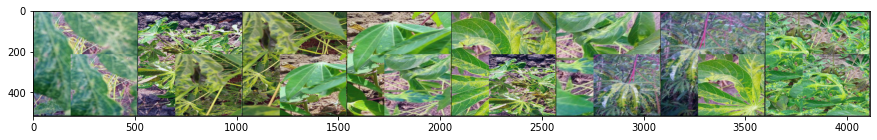

In [35]:
mixmethod = Snapmix()
img, targ = next(iter(dl))

img_mix = mixmethod(img, targ, model)
mixmethod.stop()

grid = make_grid(img_mix, normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15, 10))
plt.imshow(grid)

In [ ]:
# hide
from nbdev.export import *

notebook2script()